In [1]:
import xupy as xp
# from numpy.ma import masked_array
import matplotlib.pyplot as plt
from arte.types.mask import CircularMask

from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.zernike_wfs import ZernikeWFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator

def create_field_from_zernike_coefficients(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase_mask = project_zernike_on_mask(mask, noll_ids, amplitudes)
    return xp.asarray(mask.asTransmissionValue()) * xp.exp(1j * phase_mask)


def project_zernike_on_mask(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    zg = ZernikeGenerator(mask)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * zg.getZernike(noll)
    else:
        amplitudes *= xp.ones_like(noll_ids)
        zern = xp.zeros(mask.mask().shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * zg.getZernike(noll)

    return xp.asarray(zern)

In [3]:
def push_pull_calibrate(wfs, mask, Nmodes, lambdaOverD, method:str=None, amp:float = 0.1, show:bool=False):

    if method is not None:
        wfs._slope_method = method

    zern = create_field_from_zernike_coefficients(mask, 1, amp)
    slope = wfs.compute_slopes(zern, lambdaOverD, nPhotons=None)/amp

    IM = xp.zeros([len(slope),Nmodes])

    for i in range(Nmodes):
        noll = 2 + i
        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        push_slope = wfs.compute_slopes(input_zern, lambdaOverD, nPhotons=None)/amp

        input_zern = xp.conj(input_zern)
        pull_slope = wfs.compute_slopes(input_zern, lambdaOverD, nPhotons=None)/amp

        if i <= 8 and show:
            plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            plt.plot(xp.asnumpy(push_slope))
            plt.grid()
            plt.subplot(1,3,2)
            plt.plot(xp.asnumpy(pull_slope))
            plt.title(f'Noll {noll}')
            plt.grid()
            plt.subplot(1,3,3)
            plt.plot(xp.asnumpy((push_slope-pull_slope)/2))
            plt.grid()

        IM[:,i] = (push_slope-pull_slope)/2

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

In [4]:
def test_linearity(sc, mask, Rec, lambdaInM, D, nRecModes:int, Nmodes:int=8, title_str=''):

    lambdaOverD = lambdaInM/D
    rad2nm = lambdaInM/(2*xp.pi)*1e+9
    
    amp_vec = xp.linspace(-2,2,27,endpoint=True) #xp.linspace(-75/rad2nm,75/rad2nm,27,endpoint=True)
    mid_amp_vec = xp.linspace(-2,2,27,endpoint=True) #xp.linspace(-50/rad2nm,50/rad2nm,27,endpoint=True)
    low_amp_vec = xp.linspace(-2,2,27,endpoint=True) #xp.linspace(-25/rad2nm,25/rad2nm,27,endpoint=True)

    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(amp_vec)*rad2nm,'--')
    plt.subplot(1,3,2)
    plt.plot(xp.asnumpy(mid_amp_vec)*rad2nm,xp.asnumpy(mid_amp_vec)*rad2nm,'--')
    plt.subplot(1,3,3)
    plt.plot(xp.asnumpy(low_amp_vec)*rad2nm,xp.asnumpy(low_amp_vec)*rad2nm,'--')

    zern = create_field_from_zernike_coefficients(mask, 1, 0)
    sn = sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
    sc.slope_null = sn.copy()

    for j in range(Nmodes):

        zid = j + 2
        meas_amp = xp.zeros_like(amp_vec)

        mid_zid = nRecModes//2 + Nmodes//2 - j
        mid_meas_amp = xp.zeros_like(amp_vec)

        rev_zid = nRecModes - j
        rev_meas_amp = xp.zeros_like(amp_vec)

        for k,amp in enumerate(amp_vec):
            zern = create_field_from_zernike_coefficients(mask, zid, float(amp))
            slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
            zern_reconstructed = Rec @ slopes
            meas_amp[k] = zern_reconstructed[zid-2]

            mid_zern = create_field_from_zernike_coefficients(mask, mid_zid, float(mid_amp_vec[k]))
            slopes = sc.compute_slopes(mid_zern, lambdaOverD, nPhotons=None)
            zern_reconstructed = Rec @ slopes
            mid_meas_amp[k] = zern_reconstructed[mid_zid-2]

            rev_zern = create_field_from_zernike_coefficients(mask, rev_zid, float(low_amp_vec[k]))
            slopes = sc.compute_slopes(rev_zern, lambdaOverD, nPhotons=None)
            zern_reconstructed = Rec @ slopes
            rev_meas_amp[k] = zern_reconstructed[rev_zid-2]  

        plt.subplot(1,3,1)
        plt.plot(xp.asnumpy(amp_vec)*rad2nm, xp.asnumpy(meas_amp)*rad2nm,'-o', label=f'Noll {zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.ylabel('Measured amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

        plt.subplot(1,3,2)
        plt.plot(xp.asnumpy(mid_amp_vec)*rad2nm, xp.asnumpy(mid_meas_amp)*rad2nm,'-o', label=f'Noll {mid_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)
        
        plt.subplot(1,3,3)
        plt.plot(xp.asnumpy(low_amp_vec)*rad2nm, xp.asnumpy(rev_meas_amp)*rad2nm,'-o', label=f'Noll {rev_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

In [5]:
blueLambda = 950e-9
redLambda = 1400e-9

oversampling = 4
D = 8.2
Npix = 120
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

blueLambdaOverD = blueLambda/D
redLambdaOverD = redLambda/D

apex_angle = 128*(2*xp.pi)*redLambdaOverD
pyr = PyramidWFS(apex_angle, oversampling, sensorLambda=redLambda)
pyr_pars = {'modulationInLambdaOverD':0}

z2wfs = ZernikeWFS(lambdaInM=blueLambda, sizeInLambdaOverD=2.0, delay=xp.pi/2, oversampling=oversampling, lambdaOverD=blueLambdaOverD)
zwfs = ZernikeWFS(lambdaInM=blueLambda, sizeInLambdaOverD=1.0, delay=xp.pi/2, oversampling=oversampling, lambdaOverD=blueLambdaOverD)

RON = 0.3
rCCD = Detector((240,240),RON=RON)
bCCD = Detector((240,240),RON=RON)

In [6]:
piston = xp.asarray(mask.asTransmissionValue())

rWFS = SlopeComputer(pyr, rCCD, pyr_pars)
rWFS.calibrate_sensor(zero_phase=piston, lambdaOverD=redLambdaOverD, Npix=60, centerObscurationInPixels=0.0)
pyr.set_modulation_angle(0.0)

b2WFS = SlopeComputer(z2wfs, bCCD, {})
b2WFS.calibrate_sensor(prefix_str='zern2_')

bWFS = SlopeComputer(zwfs, bCCD, {})
bWFS.calibrate_sensor(prefix_str='zern_')

Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps


In [7]:
N = 10
nRecModes = int((N+1)*N/2)

rRec, rIM = push_pull_calibrate(rWFS, mask, nRecModes, redLambdaOverD, method='slopes', amp=5e-9/redLambda*2*xp.pi)
bRec, bIM = push_pull_calibrate(bWFS, mask, nRecModes, blueLambdaOverD, amp=5e-9/redLambda*2*xp.pi)
b2Rec, bIM = push_pull_calibrate(b2WFS, mask, nRecModes, blueLambdaOverD, amp=5e-9/redLambda*2*xp.pi)

In [8]:
# plt.figure()
# plt.imshow(xp.asnumpy(bCCD.last_frame),origin='lower',cmap='RdBu')
# plt.colorbar()

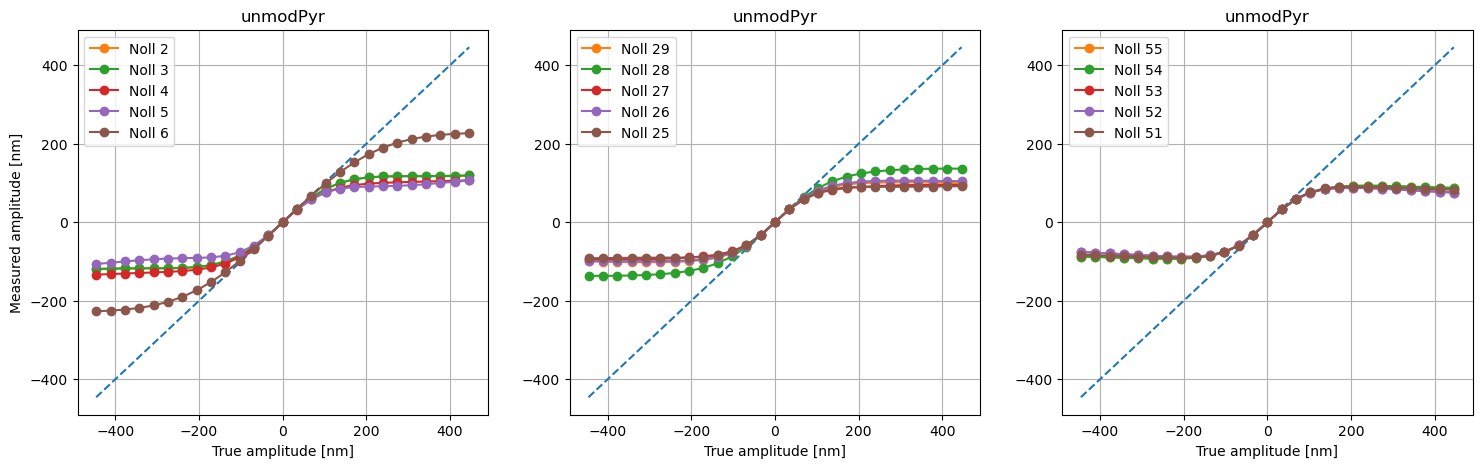

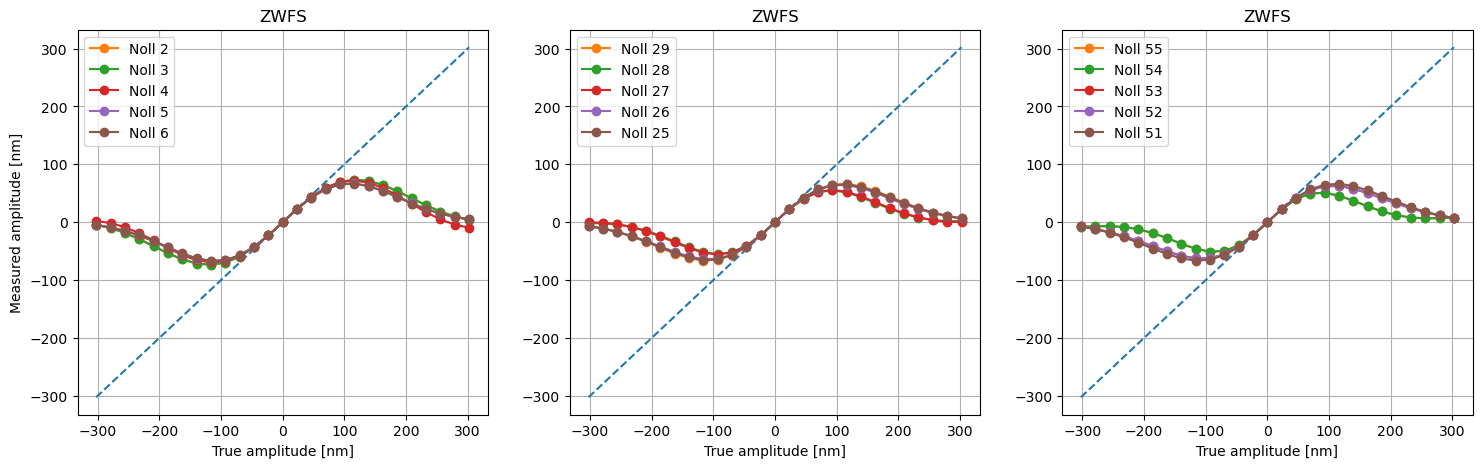

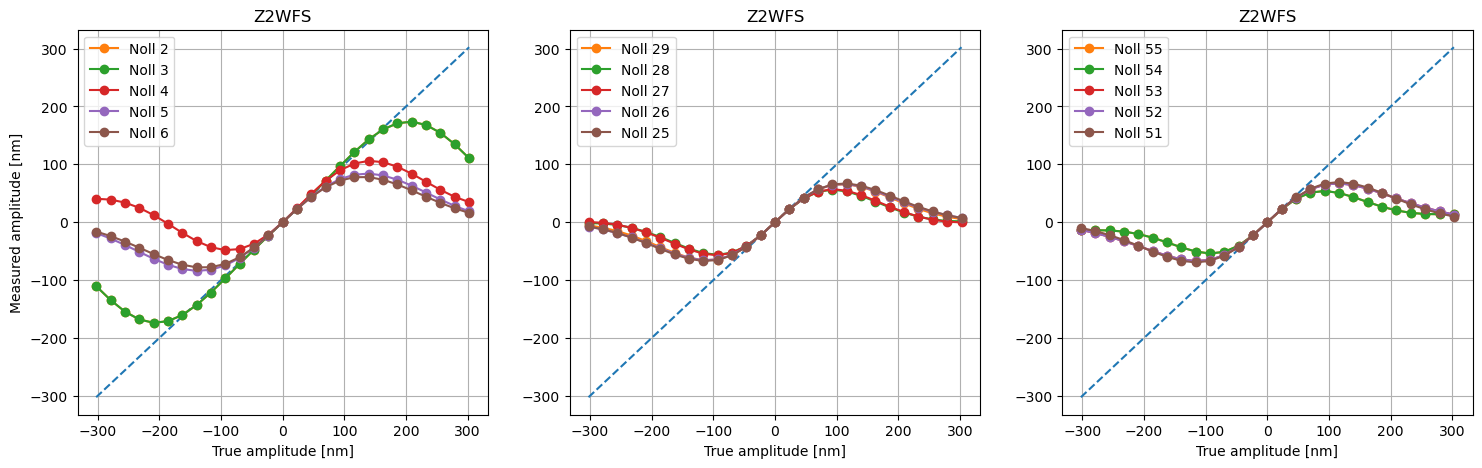

In [9]:
# Linearity check
Nmodes = 5
test_linearity(rWFS, mask, rRec, redLambda, D, nRecModes, Nmodes=Nmodes, title_str='unmodPyr')
test_linearity(bWFS, mask, bRec, blueLambda, D, nRecModes, Nmodes=Nmodes, title_str='ZWFS')
test_linearity(b2WFS, mask, b2Rec, blueLambda, D, nRecModes, Nmodes=Nmodes, title_str='Z2WFS')

In [ ]:
def combine_RB(redModes, blueModes, thr=40e-9):
    blueWeight = 0.0
    if xp.max(redModes[:2]) < thr:
        x = (xp.std(redModes))*1e+9
        blueWeight = 1.0 - 1.0/(1.0+xp.exp(-x))
    
    # if blueWeight > 0.5:
    #     print(blueWeight)
    redWeight = 1.0 - blueWeight
    modes = redModes*redWeight + blueModes*blueWeight
    return modes

def test_linearity_combinedRB(redSC, blueSC, redRec, blueRec, nRecModes:int, Nmodes:int=8, title_str='', amp=300e-9, thr:float=40e-9):
    
    amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-75/rad2nm,75/rad2nm,27,endpoint=True)
    mid_amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-50/rad2nm,50/rad2nm,27,endpoint=True)
    low_amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-25/rad2nm,25/rad2nm,27,endpoint=True)

    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(xp.asnumpy(amp_vec)*1e+9,xp.asnumpy(amp_vec)*1e+9,'--')
    plt.subplot(1,3,2)
    plt.plot(xp.asnumpy(mid_amp_vec)*1e+9,xp.asnumpy(mid_amp_vec)*1e+9,'--')
    plt.subplot(1,3,3)
    plt.plot(xp.asnumpy(low_amp_vec)*1e+9,xp.asnumpy(low_amp_vec)*1e+9,'--')

    redRad2M = redLambda/(2*xp.pi)
    blueRad2M = blueLambda/(2*xp.pi)


    for j in range(Nmodes):

        zid = j + 2
        meas_amp = xp.zeros_like(amp_vec)

        mid_zid = nRecModes//2 + Nmodes//2 - j
        mid_meas_amp = xp.zeros_like(amp_vec)

        rev_zid = nRecModes - j
        rev_meas_amp = xp.zeros_like(amp_vec)
        
        for k,amp in enumerate(amp_vec):

            bzern = create_field_from_zernike_coefficients(mask, zid, float(amp_vec[k])/blueRad2M)
            blueSlopes = blueSC.compute_slopes(bzern, blueLambdaOverD, nPhotons=None)
            blueModes = blueRec @ blueSlopes
            rzern = create_field_from_zernike_coefficients(mask, zid, float(amp_vec[k])/redRad2M)
            redSlopes = redSC.compute_slopes(rzern, redLambdaOverD, nPhotons=None)
            redModes = redRec @ redSlopes
            modes = combine_RB(redModes*redRad2M, blueModes*blueRad2M,thr=thr)
            meas_amp[k] = modes[zid-2]

            mid_bzern = create_field_from_zernike_coefficients(mask, mid_zid, float(mid_amp_vec[k])/blueRad2M)
            blueSlopes = blueSC.compute_slopes(mid_bzern, blueLambdaOverD, nPhotons=None)
            blueModes = blueRec @ blueSlopes
            mid_rzern = create_field_from_zernike_coefficients(mask, mid_zid, float(mid_amp_vec[k])/redRad2M)
            redSlopes = redSC.compute_slopes(mid_rzern, redLambdaOverD, nPhotons=None)
            redModes = redRec @ redSlopes
            modes = combine_RB(redModes*redRad2M, blueModes*blueRad2M,thr=thr)
            mid_meas_amp[k] = modes[mid_zid-2]

            rev_bzern = create_field_from_zernike_coefficients(mask, rev_zid, float(low_amp_vec[k])/blueRad2M)
            blueSlopes = blueSC.compute_slopes(rev_bzern, blueLambdaOverD, nPhotons=None)
            blueModes = blueRec @ blueSlopes
            rev_rzern = create_field_from_zernike_coefficients(mask, rev_zid, float(low_amp_vec[k])/redRad2M)
            redSlopes = redSC.compute_slopes(rev_rzern, redLambdaOverD, nPhotons=None)
            redModes = redRec @ redSlopes
            modes = combine_RB(redModes*redRad2M, blueModes*blueRad2M,thr=thr)
            rev_meas_amp[k] = modes[rev_zid-2] 

        plt.subplot(1,3,1)
        plt.plot(xp.asnumpy(amp_vec)*1e+9, xp.asnumpy(meas_amp)*1e+9,'-o', label=f'Noll {zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.ylabel('Measured amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

        plt.subplot(1,3,2)
        plt.plot(xp.asnumpy(mid_amp_vec)*1e+9, xp.asnumpy(mid_meas_amp)*1e+9,'-o', label=f'Noll {mid_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)
        
        plt.subplot(1,3,3)
        plt.plot(xp.asnumpy(low_amp_vec)*1e+9, xp.asnumpy(rev_meas_amp)*1e+9,'-o', label=f'Noll {rev_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

0.8258937501958865
0.865892269018381
0.8807158794472485
0.9958649191145217
0.9960592446428588
0.99614684278638
0.9999546021312976
0.9999546021312976
0.9999546021312976
0.9958290171773987
0.9960090100661342
0.9960637257815836
0.8607376222538251
0.8724993187564759
0.8252117827064034
0.8096791942094175
0.882938408458188
0.9958572467113457
0.9958142157981906
0.9961607771506144
0.9999546021312976
0.9999546021312976
0.9999546021312976
0.9958406541667649
0.9957407251972688
0.9960676459690245
0.7995400292310012
0.8734901174188903
0.7688628087211753
0.892733752788911
0.882033598924119
0.9953418059327488
0.9962159563145058
0.996155919197171
0.9999546021312976
0.9999546021312976
0.9999546021312976
0.9964081144217491
0.9961513298096696
0.9960676863417761
0.8883909938470659
0.8872008326534849
0.8737610035293661
0.8807768341537273
0.8679649575110588
0.8819272255686417
0.9961290909218962
0.9961219430299164
0.9961549565643425
0.9999546021312976
0.9999546021312976
0.9999546021312976
0.9960895650897386


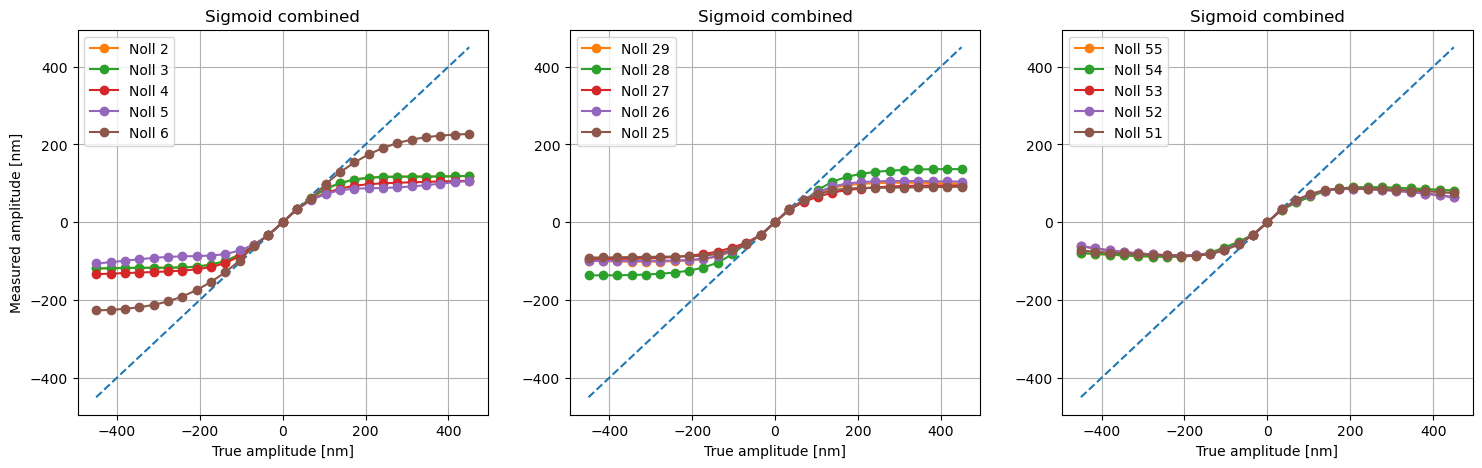

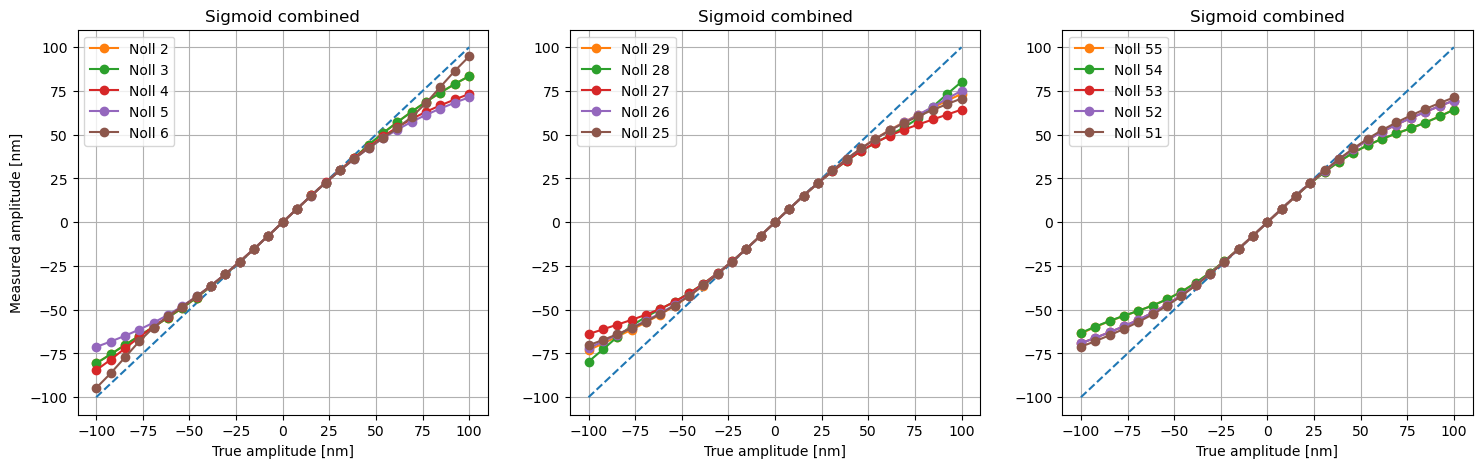

In [20]:
test_linearity_combinedRB(redSC=rWFS, blueSC=bWFS, redRec=rRec, blueRec=bRec, nRecModes=nRecModes, Nmodes=5, amp=450e-9, title_str='Sigmoid combined')
test_linearity_combinedRB(redSC=rWFS, blueSC=bWFS, redRec=rRec, blueRec=bRec, nRecModes=nRecModes, Nmodes=5, amp=100e-9, title_str='Sigmoid combined')

In [ ]:
def compute_combined_slopes(ampInM, noll, nPhotons, w:float=0.0):
    redM2rad = 2*xp.pi/redLambda
    blueM2rad = 2*xp.pi/blueLambda
    redAmp = ampInM*redM2rad*(1-w)
    redAb = create_field_from_zernike_coefficients(mask, noll, redAmp)
    redAmps = rWFS.compute_slopes(redAb, redLambdaOverD, nPhotons=nPhotons)/redM2rad
    blueAmp = ampInM*blueM2rad*(1+w)
    blueAb = create_field_from_zernike_coefficients(mask, noll, blueAmp)
    blueAmps = bWFS.compute_slopes(blueAb, blueLambdaOverD, nPhotons=nPhotons)/blueM2rad
    slopes = xp.hstack([redAmps,blueAmps])
    return slopes

def push_pull_calibrate_combined(Nmodes, ampInM:float = 10e-9, nPhotons=None, show:bool=False, w:float=0.0):

    slope = compute_combined_slopes(ampInM, 1, nPhotons)
    IM = xp.zeros([len(slope),Nmodes])

    for i in range(Nmodes):
        noll = 2 + i
        push_slope = compute_combined_slopes(ampInM, noll, nPhotons, w=w)/ampInM

        pull_slope = compute_combined_slopes(-ampInM, noll, nPhotons, w=w)/ampInM

        if i <= 8 and show:
            plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            plt.plot(xp.asnumpy(push_slope))
            plt.grid()
            plt.subplot(1,3,2)
            plt.plot(xp.asnumpy(pull_slope))
            plt.title(f'Noll {noll}')
            plt.grid()
            plt.subplot(1,3,3)
            plt.plot(xp.asnumpy((push_slope-pull_slope)/2))
            plt.grid()

        IM[:,i] = (push_slope-pull_slope)/2

    Rec = xp.linalg.pinv(IM)

    return Rec, IM


def test_linearity_combined(Rec, nRecModes:int, Nmodes:int=8, title_str='', amp=300e-9, w:float=0.0):
    
    amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-75/rad2nm,75/rad2nm,27,endpoint=True)
    mid_amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-50/rad2nm,50/rad2nm,27,endpoint=True)
    low_amp_vec = xp.linspace(-amp,amp,27,endpoint=True) #xp.linspace(-25/rad2nm,25/rad2nm,27,endpoint=True)

    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(xp.asnumpy(amp_vec)*1e+9,xp.asnumpy(amp_vec)*1e+9,'--')
    plt.subplot(1,3,2)
    plt.plot(xp.asnumpy(mid_amp_vec)*1e+9,xp.asnumpy(mid_amp_vec)*1e+9,'--')
    plt.subplot(1,3,3)
    plt.plot(xp.asnumpy(low_amp_vec)*1e+9,xp.asnumpy(low_amp_vec)*1e+9,'--')


    for j in range(Nmodes):

        zid = j + 2
        meas_amp = xp.zeros_like(amp_vec)

        mid_zid = nRecModes//2 + Nmodes//2 - j
        mid_meas_amp = xp.zeros_like(amp_vec)

        rev_zid = nRecModes - j
        rev_meas_amp = xp.zeros_like(amp_vec)

        for k,amp in enumerate(amp_vec):
            slopes = compute_combined_slopes(ampInM=float(amp), noll=zid, nPhotons=None, w=w)
            zern_reconstructed = Rec @ slopes
            meas_amp[k] = zern_reconstructed[zid-2]

            slopes = compute_combined_slopes(ampInM=float(mid_amp_vec[k]), noll=mid_zid, nPhotons=None, w=w)
            zern_reconstructed = Rec @ slopes
            mid_meas_amp[k] = zern_reconstructed[mid_zid-2]

            slopes = compute_combined_slopes(ampInM=float(low_amp_vec[k]), noll=rev_zid, nPhotons=None, w=w)
            zern_reconstructed = Rec @ slopes
            rev_meas_amp[k] = zern_reconstructed[rev_zid-2]  

        plt.subplot(1,3,1)
        plt.plot(xp.asnumpy(amp_vec)*1e+9, xp.asnumpy(meas_amp)*1e+9,'-o', label=f'Noll {zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.ylabel('Measured amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

        plt.subplot(1,3,2)
        plt.plot(xp.asnumpy(mid_amp_vec)*1e+9, xp.asnumpy(mid_meas_amp)*1e+9,'-o', label=f'Noll {mid_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)
        
        plt.subplot(1,3,3)
        plt.plot(xp.asnumpy(low_amp_vec)*1e+9, xp.asnumpy(rev_meas_amp)*1e+9,'-o', label=f'Noll {rev_zid}')
        plt.legend(loc='best')
        plt.xlabel('True amplitude [nm]')
        plt.title(title_str)
        plt.grid(True)

In [ ]:
cRec, cIM = push_pull_calibrate_combined(nRecModes, ampInM=5e-9, nPhotons=None)#, show=True, w=w)

IM_norm = cIM.copy()
nPyrSlopes = len(rWFS.compute_slopes(1-xp.asarray(mask.mask()), redLambdaOverD, nPhotons=None))
nZernSlopes = xp.shape(cIM)[0]-nPyrSlopes
IM_norm[:nPyrSlopes,:] *= nZernSlopes/nPyrSlopes
IM_norm[nPyrSlopes:,:] *= nPyrSlopes/nZernSlopes

Rec_norm = xp.linalg.pinv(IM_norm)

In [ ]:
# IM = xp.vstack((rIM*redLambda/blueLambda,bIM))
# R = xp.linalg.pinv(IM)

# plt.figure(figsize=(16,3.5))
# plt.subplot(1,4,1)
# plt.imshow(xp.asnumpy(IM),origin='lower')
# plt.colorbar()
# plt.axis([0,50,0,50])
# plt.subplot(1,4,2)
# plt.imshow(xp.asnumpy(cIM),origin='lower')
# plt.colorbar()
# plt.axis([0,50,0,50])
# plt.subplot(1,4,3)
# plt.imshow(xp.asnumpy(cRec @ IM),origin='lower')
# plt.colorbar()
# plt.axis([0,50,0,50])
# plt.subplot(1,4,4)
# plt.imshow(xp.asnumpy(R @ cIM),origin='lower')
# plt.colorbar()
# plt.axis([0,50,0,50])

# plt.figure(figsize=(8,3.5))
# plt.subplot(1,2,1)
# plt.imshow(xp.asnumpy(cRec),origin='lower')
# plt.colorbar()
# plt.axis([0,50,0,50])
# plt.subplot(1,2,2)
# plt.imshow(xp.asnumpy(cRec),origin='lower')
# plt.colorbar()
# plt.axis([8000,8050,0,50])

# plt.figure()
# plt.imshow(xp.asnumpy(cRec),origin='lower')
# plt.colorbar()
# plt.axis([5500,5700,0,50])

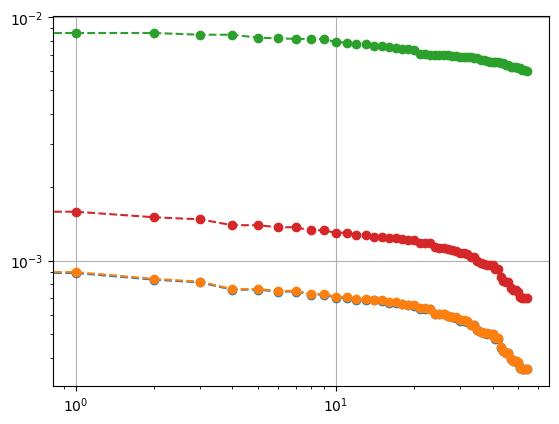

In [ ]:
cD = xp.linalg.svd(cRec,compute_uv=False)
rD = xp.linalg.svd(rRec,compute_uv=False)
bD = xp.linalg.svd(bRec,compute_uv=False)
D = xp.linalg.svd(Rec_norm,compute_uv=False)

plt.figure()
plt.plot(xp.asnumpy(cD),'--o')#xp.diag(cIM.T @ cIM)),'--o')
plt.plot(xp.asnumpy(rD),'--o')#xp.diag(rIM.T @ rIM)),'--o')
plt.plot(xp.asnumpy(bD),'--o')#xp.diag(bIM.T @ bIM)),'--o')
plt.plot(xp.asnumpy(D),'--o')#xp.diag(bIM.T @ bIM)),'--o')
plt.xscale('log')
plt.yscale('log')
plt.grid()

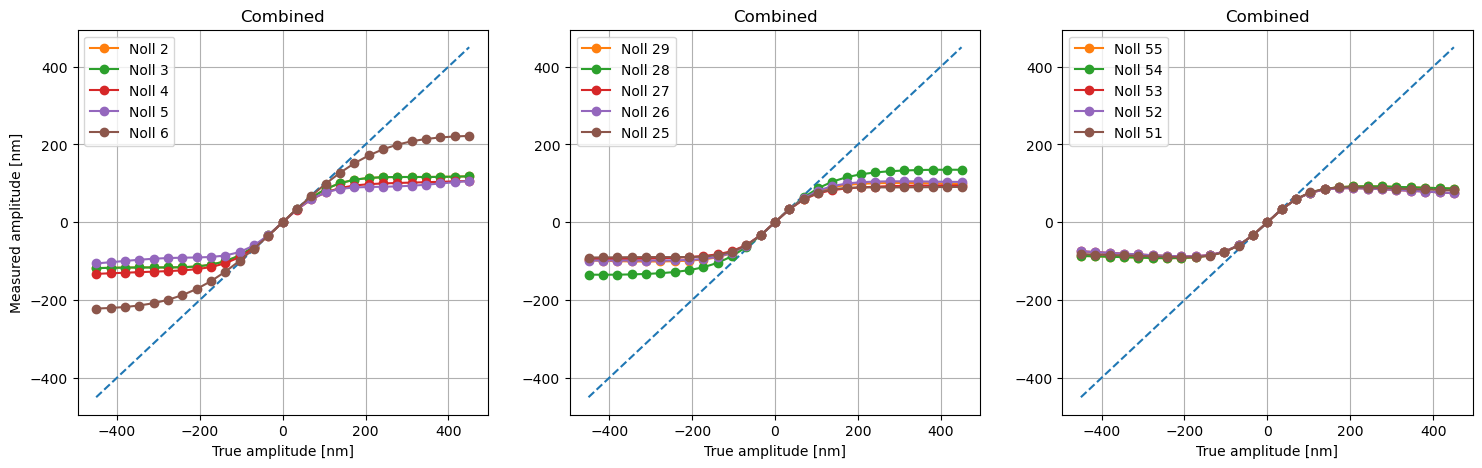

In [ ]:
# Linearity check
Nmodes = 5
test_linearity_combined(cRec, nRecModes, Nmodes=Nmodes, title_str='Combined', amp=450e-9, w=0.0)
# test_linearity_combined(Rec_norm, nRecModes, Nmodes=Nmodes, title_str='Combined', amp=450e-9, w=0.0)

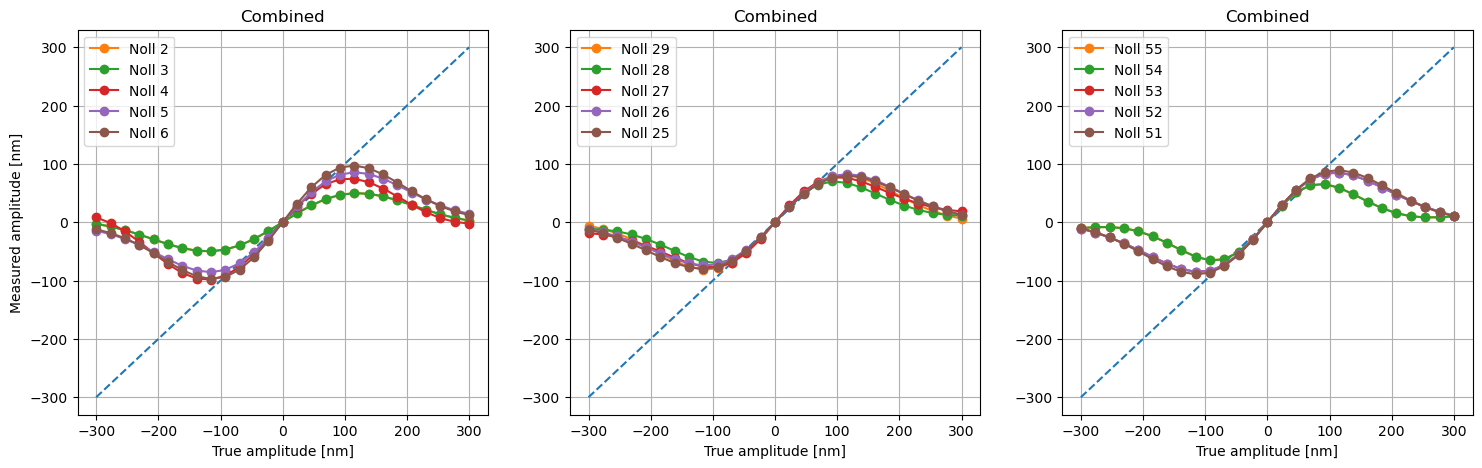

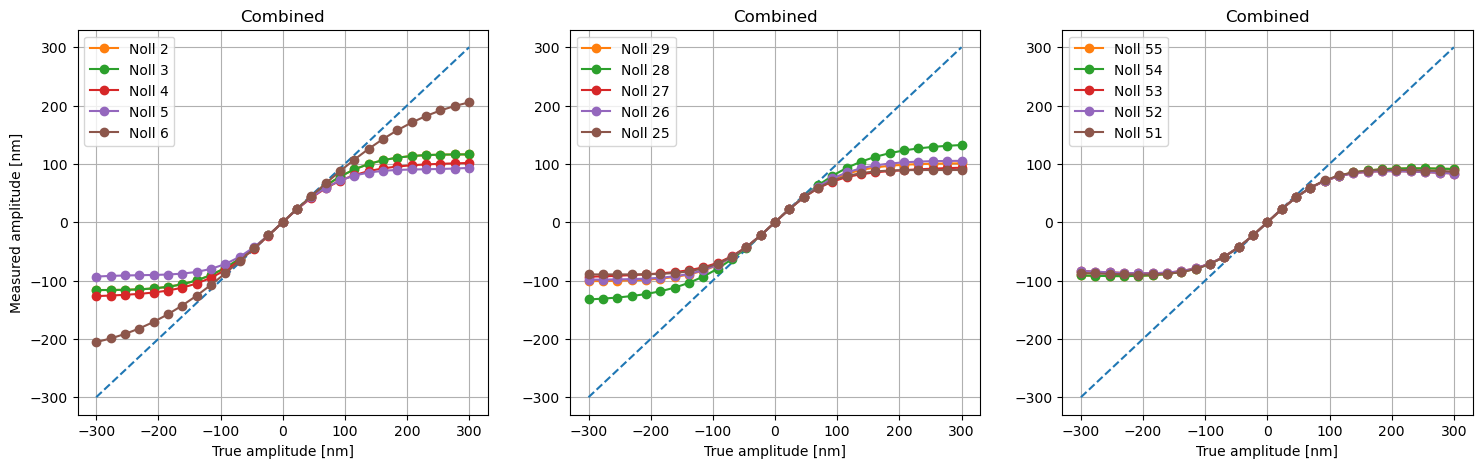

In [ ]:

nPyrSlopes = len(rWFS.compute_slopes(1-xp.asarray(mask.mask()), redLambdaOverD, nPhotons=None))
pyrRec = cRec.copy()
pyrRec[:,nPyrSlopes:] *= 0
zernRec = cRec.copy()
zernRec[:,:nPyrSlopes] *= 0

dd = xp.std(cRec[:,:nPyrSlopes],axis=1)/xp.std(cRec[:,nPyrSlopes:],axis=1)
coeff = redLambda/blueLambda * nPyrSlopes/(xp.shape(cRec)[1]-nPyrSlopes)

# plt.figure()
# # plt.plot((xp.std(cRec,axis=1)/xp.std(cRec,axis=1)).get())
# # plt.plot((xp.std(cRec[:,nPyrSlopes:],axis=1)/xp.std(cRec,axis=1)).get())
# plt.plot((dd).get()**2)
# plt.grid()
# # plt.yscale('log')

test_linearity_combined(coeff*zernRec*xp.tile((dd**2).reshape([xp.shape(cRec)[0],1]),(1,xp.shape(cRec)[1])), nRecModes, Nmodes=Nmodes, title_str='Combined', amp=300e-9, w=0.0)
test_linearity_combined(pyrRec, nRecModes, Nmodes=Nmodes, title_str='Combined', amp=300e-9, w=0.0)
# test_linearity_combined(zernRec*100+pyrRec, nRecModes, Nmodes=Nmodes, title_str='Combined', amp=300e-9, w=0.0)

In [ ]:
# def sigma_rec(IM, nPyrSlopes:int, sigma):
#     # weighted_IM = IM.copy()
#     # nZernSlopes = IM.shape[0]-nPyrSlopes
#     # print(nPyrSlopes/nZernSlopes)
#     # weighted_IM[nPyrSlopes:,:] *= 1+sigma
#     # weighted_IM[:nPyrSlopes,:] /= 1+sigma#*nZernSlopes/nPyrSlopes
#     # sigRec = xp.linalg.pinv(weighted_IM)
#     U,S,Vt = xp.linalg.svd(IM,full_matrices=False)
#     SIGMA = 1/S
#     SIGMA[nPyrSlopes:] *= 1/sigma
#     SIGMA[:nPyrSlopes] *= sigma
#     sigRec = (Vt.T * SIGMA) @ U.T
#     return sigRec

# def sigma_rec(Rec, nPyrSlopes, sigma):
#     sigRec = Rec.copy()
#     coeff = redLambda/blueLambda * nPyrSlopes/(xp.shape(cRec)[1]-nPyrSlopes)
#     dd = xp.std(Rec[:,:nPyrSlopes],axis=1)/xp.std(Rec[:,nPyrSlopes:],axis=1)
#     norm = xp.tile((dd**2).reshape([xp.shape(Rec)[0],1]),(1,xp.shape(Rec)[1]-nPyrSlopes))*coeff
#     sigRec[:,nPyrSlopes:] *= norm*sigma
#     sigRec[:,:nPyrSlopes] /= sigma
#     return sigRec

def sigma_rec(Rec, nPyrSlopes, sigma):
    sigRec = Rec.copy()
    sigRec[:,nPyrSlopes:] *= sigma/xp.shape(Rec[:,nPyrSlopes:])[1]
    sigRec[:,:nPyrSlopes] /= sigma/nPyrSlopes
    return sigRec

nPyrSlopes = len(rWFS.compute_slopes(1-xp.asarray(mask.mask()), redLambdaOverD, nPhotons=None))
sigRec = sigma_rec(cRec, nPyrSlopes=nPyrSlopes, sigma=2)

test_linearity_combined(sigRec, nRecModes, Nmodes=Nmodes, title_str='Combined', amp=450e-9, w=0.0)

KeyboardInterrupt: 

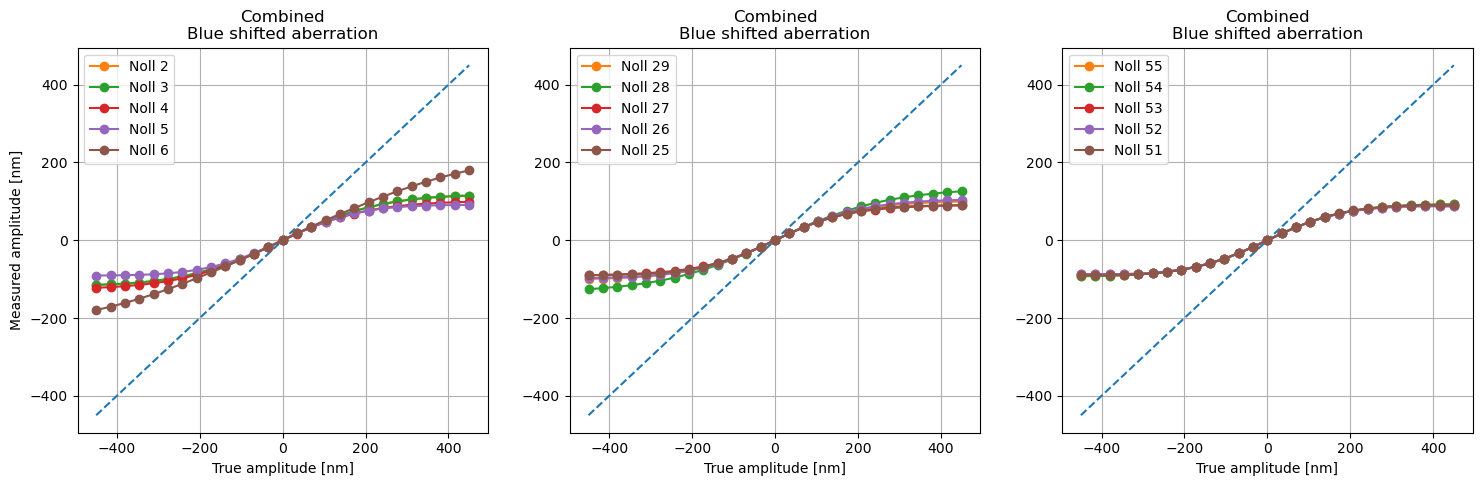

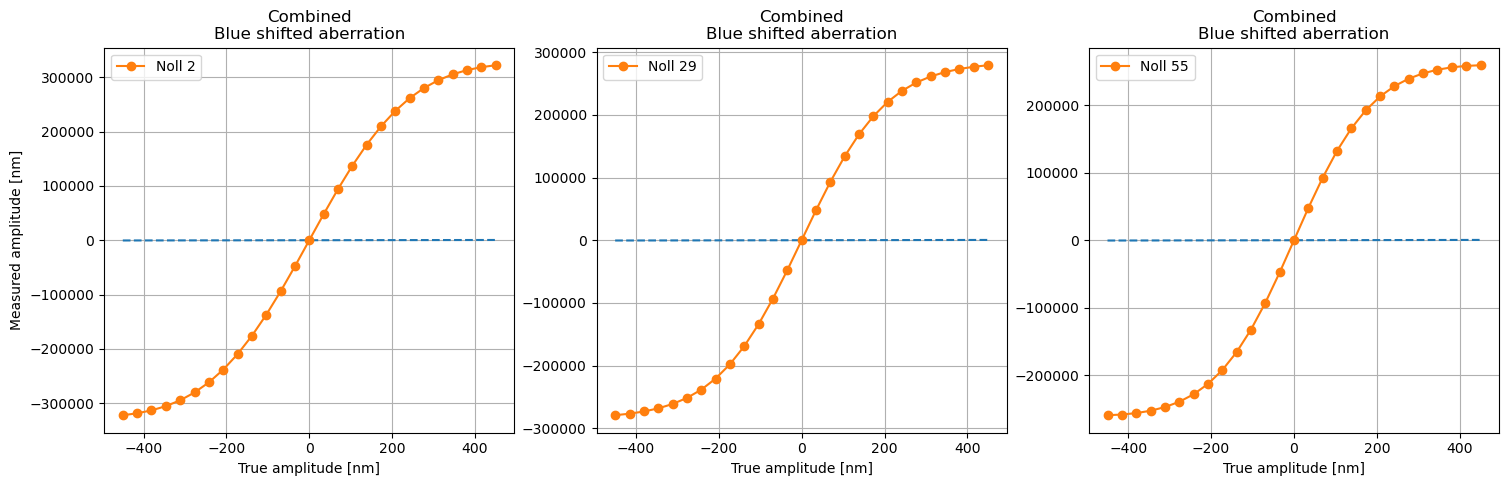

In [ ]:
test_linearity_combined(cRec, nRecModes, Nmodes=Nmodes, title_str='Combined\nBlue shifted aberration', amp=450e-9, w=0.5)
test_linearity_combined(sigRec, nRecModes, Nmodes=Nmodes, title_str='Combined\nBlue shifted aberration', amp=450e-9, w=0.5)

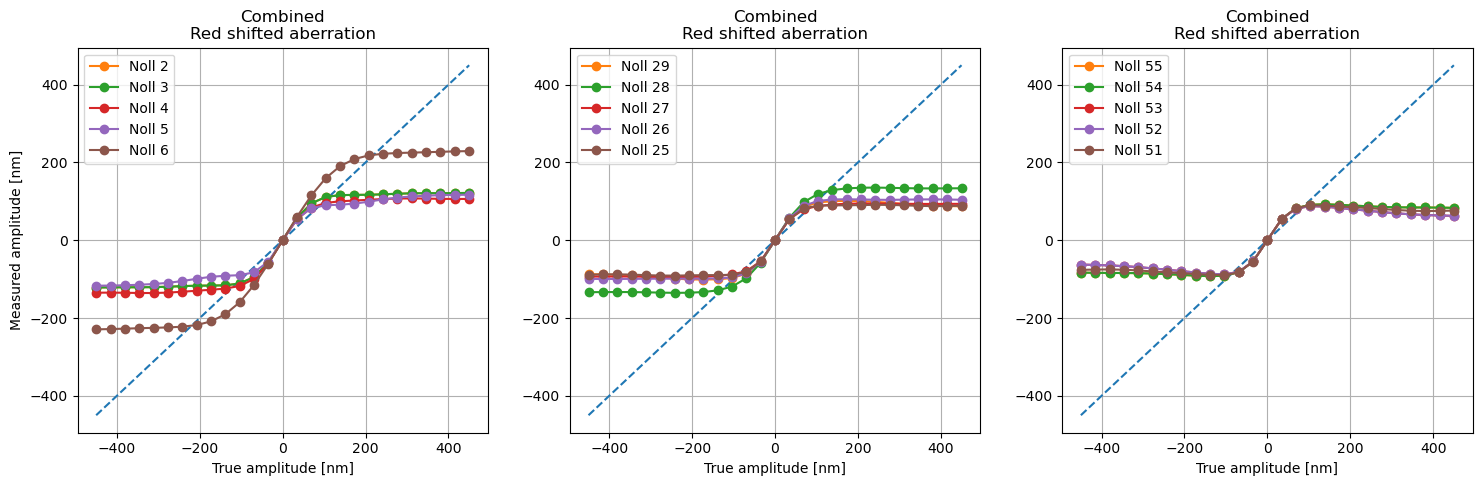

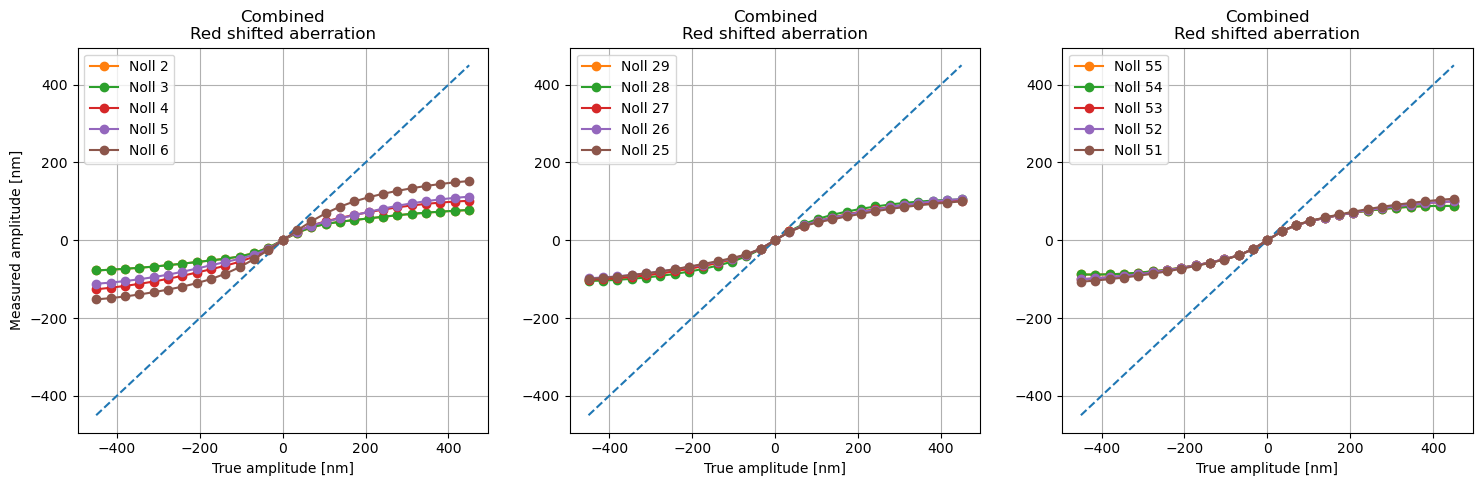

In [ ]:
test_linearity_combined(cRec, nRecModes, Nmodes=Nmodes, title_str='Combined\nRed shifted aberration', amp=450e-9, w=-0.8)
test_linearity_combined(sigRec, nRecModes, Nmodes=Nmodes, title_str='Combined\nRed shifted aberration', amp=450e-9, w=-0.8)